In [1]:
import numpy as np
import random
import torch
from torch import nn, optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# import cifar10_model as cifar10_model
# model_file="cifar10_model.pt"
# epochs=50
# end_loss=0.65

In [3]:
import cifar10_resnet as cifar10_model
model_file="cifar10_resnet.pt"
epochs=10
end_loss=0.45

In [4]:
torch.manual_seed(10)
np.random.seed(10)
random.seed(10)

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914,0.4822,0.4465),
        std=(0.2470,0.2435,0.2616))
])

In [6]:
train_data=datasets.CIFAR10('data/cifar10/train',train=True,download=True,transform=transform)
print(train_data.data.shape)

Files already downloaded and verified
(50000, 32, 32, 3)


In [7]:
dev_size=0.2
idx=list(range(len(train_data)))
np.random.shuffle(idx)
split_size=int(np.floor(dev_size*len(train_data)))
train_idx, dev_idx=idx[split_size:], idx[:split_size]
train_sampler=SubsetRandomSampler(train_idx)
dev_sampler=SubsetRandomSampler(dev_idx)

In [8]:
batch_size=100
train_loader= DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)
dev_loader= DataLoader(train_data,batch_size=batch_size,sampler=dev_sampler)
print(len(train_loader),len(dev_loader))

400 100


In [9]:
data_batch,label_batch=next(iter(train_loader))
print(data_batch.size(),label_batch.size())

torch.Size([100, 3, 32, 32]) torch.Size([100])


In [10]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"deivce:{device}")

deivce:cuda


In [11]:
model=cifar10_model.CNN().to(device)

In [12]:
loss_function=nn.NLLLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [13]:
train_losses=[]
dev_losses=[]
x_axis=[]
for epoch in range(epochs+1):
    train_loss=0
    # 訓練資料
    model.train()
    for data,target in tqdm(train_loader):        
        data=data.to(device)
        target=target.to(device)
        
        pred=model(data)
        loss=loss_function(pred,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    train_loss=train_loss/len(train_loader)
    
    x_axis.append(epoch)
    with torch.no_grad():
        dev_loss=0
        # 驗證資料
        model.eval()
        for data_dev,target_dev in tqdm(dev_loader):               
            data_dev=data_dev.to(device)
            target_dev=target_dev.to(device)

            dev_pred=model(data_dev)
            loss2=loss_function(dev_pred,target_dev)
            dev_loss += loss2.item()

        dev_loss=dev_loss/len(dev_loader)

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    print(f"epoch: {epoch}, Train_loss: {train_loss:.3f}, Valid_loss: {dev_loss:.3f}")
    
    if train_loss < end_loss:
        break

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.77it/s]


epoch: 0, Train_loss: 1.207, Valid_loss: 0.966


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.30it/s]


epoch: 1, Train_loss: 0.795, Valid_loss: 0.774


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.74it/s]


epoch: 2, Train_loss: 0.637, Valid_loss: 0.782


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.83it/s]


epoch: 3, Train_loss: 0.531, Valid_loss: 0.680


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.77it/s]

epoch: 4, Train_loss: 0.443, Valid_loss: 0.567


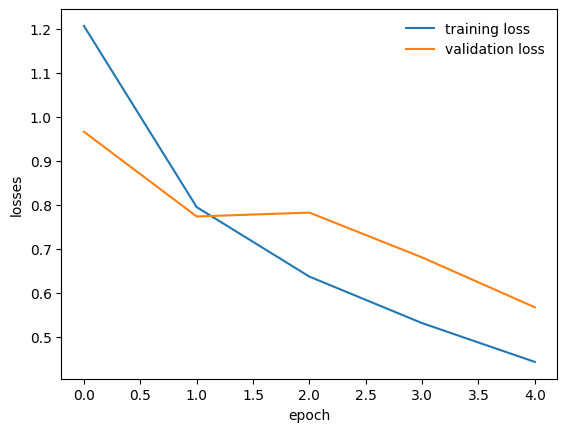

In [14]:
plt.plot(x_axis,train_losses,label="training loss")
plt.plot(x_axis,dev_losses,label="validation loss")
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.show()

In [15]:
model=model.to("cpu")
torch.save(model.state_dict(),model_file)